# Complete Note book

### Importing libraries 

In [1]:
# Core ROS and robotics libraries
import rospy
import actionlib
import math
import time
import threading
#visulization or plo
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
%matplotlib widget


# ROS message types
from geometry_msgs.msg import Point, PoseStamped
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from assignment_2_2024.msg import PlanningAction, PlanningGoal

# Interactive widgets
import ipywidgets as widgets
from IPython.display import display


### Initializing ROS node

In [2]:
# Initialize ROS node (only run this once)
try:
    rospy.init_node('Robot_interface', anonymous=True)
    rospy.loginfo("ROS node initialized")
except rospy.ROSException:
    rospy.logwarn("ROS node already exists")

# Verify ROS master connection
try:
    rospy.get_master().getPid()
    print("✅ Connected to ROS master")
except:
    print("❌ Failed to connect to ROS master")
    raise
    
# Connect to action client
action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
action_client.wait_for_server()
rospy.loginfo("Action server connected!")

reached_targets = 0
failed_targets = 0
closest_obstacle = float('inf')


[INFO] [1746976655.976757, 0.000000]: ROS node initialized
✅ Connected to ROS master
[INFO] [1746976656.058111, 2853.068000]: Action server connected!


[ERROR] [1746977179.289824, 3255.612000]: Got a transition callback on a goal handle that we're not tracking
[ERROR] [1746977179.304156, 3255.615000]: Got a transition callback on a goal handle that we're not tracking


### Setting the buttons and UI

In [3]:
# Input fields
x_input = widgets.FloatText(description="Target X:")
y_input = widgets.FloatText(description="Target Y:")

# Control buttons
set_btn = widgets.Button(description="Set Goal", button_style='success')
cancel_btn = widgets.Button(description="Cancel Goal", button_style='danger')
closest_obstacle_display = widgets.HTML(value="<b>closest obstacle:</b> (0.00 m)")

# Status displays
position_label = widgets.Label()
distance_label = widgets.Label()
status_output = widgets.Output()

controls = widgets.VBox([
    widgets.HBox([x_input, y_input]),
    widgets.HBox([set_btn, cancel_btn]),
    status_output,
    closest_obstacle_display
])

### Setting the plots and showing the UI

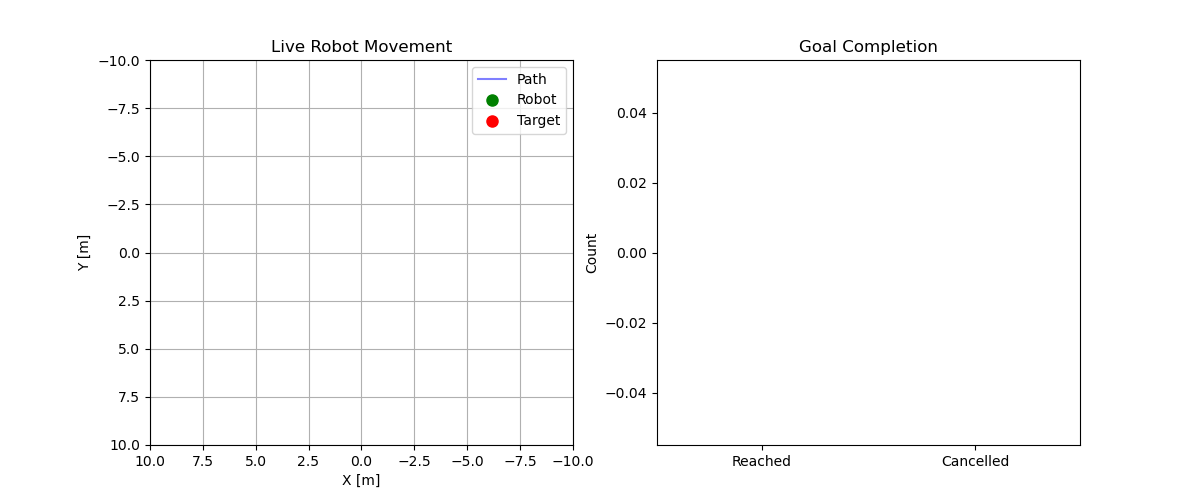

In [11]:

# Create persistent figure object
plt.close('all')
fig, (ax_pos, ax_stats) = plt.subplots(1, 2, figsize=(12,5))

# Position plot setup
ax_pos.set_title('Live Robot Movement')
ax_pos.set_xlabel('X [m]')
ax_pos.set_ylabel('Y [m]')
ax_pos.set_xlim(10, -10)
ax_pos.set_ylim(10, -10)
ax_pos.grid(True)

path_history = {'x': [], 'y': []}

# Initialize plot elements
path_line, = ax_pos.plot([], [], 'b-', alpha=0.5, label='Path')  # Blue path
current_pos = ax_pos.plot([], [], 'go', markersize=8, label='Robot')[0]  # Green dot (current)
#initial_pos = ax_pos.plot([], [], 'ro', markersize=8, label='Start')[0]  # Red dot (initial)
target_pos = ax_pos.plot([], [], 'ro', markersize=8, label='Target')[0]  # Red dot (target)
ax_pos.legend()

# Auto-scale
#ax_pos.relim()
#ax_pos.autoscale_view()

# Stats plot setup
status_bars = ax_stats.bar(['Reached', 'Cancelled'], [0, 0], color=['green', 'red'])
ax_stats.set_title('Goal Completion')
ax_stats.set_ylabel('Count')

display(widgets.HBox([controls]))

### setting my goal target and other logic and shows the updated graph

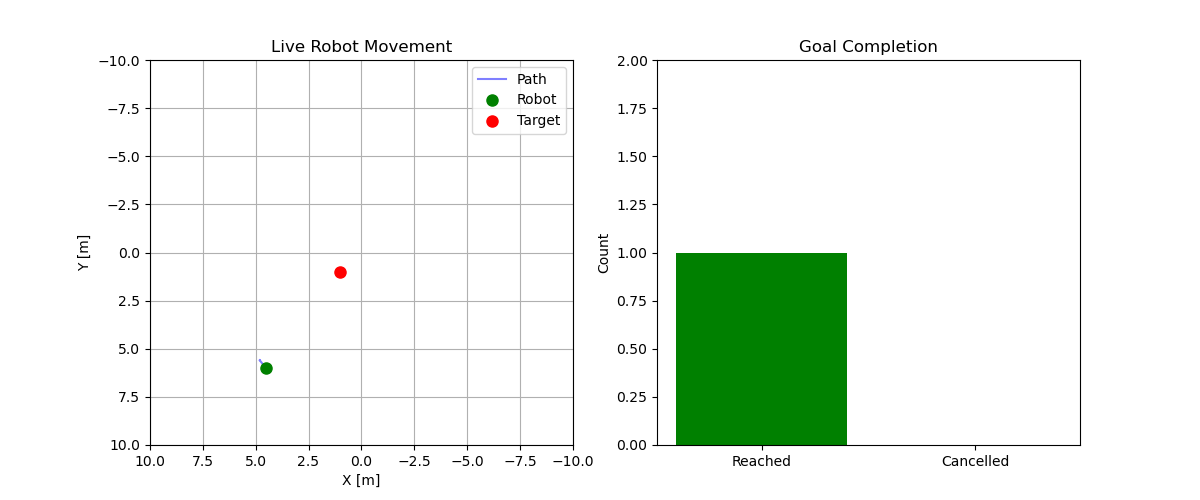

In [12]:
def update_plots(frame):
    global reached_targets, failed_targets, path_history, current_goal
    
    if path_history['x']:
        path_line.set_data(path_history['x'], path_history['y'])
        current_pos.set_data(path_history['x'][-1], path_history['y'][-1])  # Green dot
        
        if hasattr(current_goal, '__len__') and len(current_goal) == 2:
            target_pos.set_data(current_goal[0], current_goal[1])  # Red dot (target)
        
        # Auto-adjust view
        #ax_pos.relim()
        #ax_pos.autoscale_view()
    
    # Update statistics
    status_bars[0].set_height(reached_targets)
    status_bars[1].set_height(failed_targets)
    ax_stats.set_ylim(0, max(reached_targets, failed_targets, 1) + 1)
    
    return [path_line, current_pos, target_pos] + list(status_bars)

ani = FuncAnimation(fig, update_plots, interval=100, blit=True, save_count=100, cache_frame_data=False)
plt.show()


def set_goal(_):
    global current_goal
    
    goal = PlanningGoal()
    goal.target_pose = PoseStamped()
    goal.target_pose.pose.position.x = x_input.value
    goal.target_pose.pose.position.y = y_input.value
    
    # Track new goal
    current_goal = [x_input.value, y_input.value]
  
    # Send and update
    action_client.send_goal(goal, feedback_cb=feedback_callback)
    with status_output:
        print(f"Moving to: ({x_input.value}, {y_input.value})")


def cancel_goal(_):
    global current_goal, failed_targets
    action_client.cancel_goal()
    current_goal = [None, None]
    with status_output:
        print("Goal cancelled")
    
    failed_targets += 1

      
def scan_callback(msg):
    global closest_obstacle
    valid_ranges=[r for r in msg.ranges if msg.range_min<r<msg.range_max]
    if valid_ranges:
        closest_obstacle=min(valid_ranges)
        closest_obstacle_display.value = f"<b>closest obstacle:</b> ({closest_obstacle:.2f} m)"

def feedback_callback(feedback):
    global goal_active, reached_targets
    
    if feedback.stat == "Target reached!":
        reached_targets += 1

initial_position_recorded = False  # Global flag


def odom_callback(msg):
    global path_history, initial_position_recorded
    
    # Record initial position only once
    if not initial_position_recorded and msg.pose.pose.position.x != 0:
        initial_pos.set_data([msg.pose.pose.position.x], [msg.pose.pose.position.y])
        initial_position_recorded = True
    
    # Update path history
    path_history['x'].append(msg.pose.pose.position.x)
    path_history['y'].append(msg.pose.pose.position.y)
    
    # Limit stored points
    if len(path_history['x']) > 1000:
        path_history['x'] = path_history['x'][-1000:]
        path_history['y'] = path_history['y'][-1000:]
        
            
# Connect buttons
rospy.Subscriber('/scan',LaserScan,scan_callback)
rospy.Subscriber('/odom', Odometry, odom_callback)

#display(widgets.HBox([controls]))
set_btn.on_click(set_goal)
cancel_btn.on_click(cancel_goal)

